<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Cell-Metadata" data-toc-modified-id="Cell-Metadata-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Cell Metadata</a></span></li><li><span><a href="#Adata" data-toc-modified-id="Adata-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Adata</a></span></li></ul></li><li><span><a href="#Scale" data-toc-modified-id="Scale-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Scale</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>PCA</a></span><ul class="toc-item"><li><span><a href="#mCH" data-toc-modified-id="mCH-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>mCH</a></span></li><li><span><a href="#mCG" data-toc-modified-id="mCG-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>mCG</a></span></li><li><span><a href="#Concatenate" data-toc-modified-id="Concatenate-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Concatenate</a></span></li></ul></li><li><span><a href="#KNN" data-toc-modified-id="KNN-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>KNN</a></span></li><li><span><a href="#Simple-Leiden" data-toc-modified-id="Simple-Leiden-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Simple Leiden</a></span></li><li><span><a href="#UMAP" data-toc-modified-id="UMAP-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>UMAP</a></span></li><li><span><a href="#tSNE" data-toc-modified-id="tSNE-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>tSNE</a></span></li><li><span><a href="#Save-adata" data-toc-modified-id="Save-adata-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Save adata</a></span></li><li><span><a href="#Get-cell-tidy-data" data-toc-modified-id="Get-cell-tidy-data-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Get cell tidy data</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Plotting</a></span><ul class="toc-item"><li><span><a href="#Metadata-cols" data-toc-modified-id="Metadata-cols-14.1"><span class="toc-item-num">14.1&nbsp;&nbsp;</span>Metadata cols</a></span></li></ul></li></ul></div>

# Dimension Reduction and Manifold Learning

## Purpose
- PCA or batch corrected PCA
- Simple Leiden clustering
- UMAP and tSNE

## Input
- mCH HVF adata
- mCG HVG adata

## Output
- integrated adata with PC matrix
- cell tidy data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc
import seaborn as sns
from ALLCools.mcds.MCDS import MCDS
from cemba_data.plot import *
from cemba_data.tools.hdf5.anndata import batch_correct_pc

In [3]:
result_dir = pathlib.Path('Coords')
result_dir.mkdir(exist_ok=True)
fig_dir = pathlib.Path('fig/dimension_reduction')
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell

ch_pc_components = 30
cg_pc_components = 15
pc_color_col = None

batch_correction_col = None
sigma = 15
alpha = 0.1
scanorama_k = 25

n_neighbors = 25
resolution = 0.8

perplexity = 50

metadata_category_cols = ['Region']
metadata_continue_cols = ['CG_RateAdj', 'CH_RateAdj', 'FinalReads']

cell_meta_path = 'CellMetadata.AfterQC.msg'
ch_adata_path = './Adata/mch_adata.norm_per_cell.hvf.h5ad'
cg_adata_path = './Adata/mcg_adata.norm_per_cell.hvf.h5ad'

In [5]:
# Parameters
ch_pc_components = 20
cg_pc_components = 10
pc_color_col = None
batch_correction_col = None
sigma = 15
alpha = 0.1
scanorama_k = 25
n_neighbors = 25
resolution = 0.8
perplexity = 50
metadata_category_cols = ["Region"]
metadata_continue_cols = ["CG_RateAdj", "CH_RateAdj", "FinalReads"]


## Load

### Cell Metadata

In [6]:
cell_meta = pd.read_msgpack(cell_meta_path)

### Adata

In [7]:
ch_adata = anndata.read_h5ad(ch_adata_path)
cg_adata = anndata.read_h5ad(cg_adata_path)

## Scale

In [8]:
sc.pp.scale(ch_adata)
sc.pp.scale(cg_adata)

## PCA

### mCH

In [9]:
if batch_correction_col is None:
    sc.tl.pca(ch_adata, n_comps=50)
else:
    ch_adata.obs[batch_correction_col] = cell_meta[
        batch_correction_col].astype('category')
    ch_adata = batch_correct_pc(
        ch_adata,
        correct=True,
        batch_series=ch_adata.obs[batch_correction_col],
        dimred=50,
        sigma=sigma,
        alpha=alpha,
        knn=scanorama_k,
        metric='angular')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


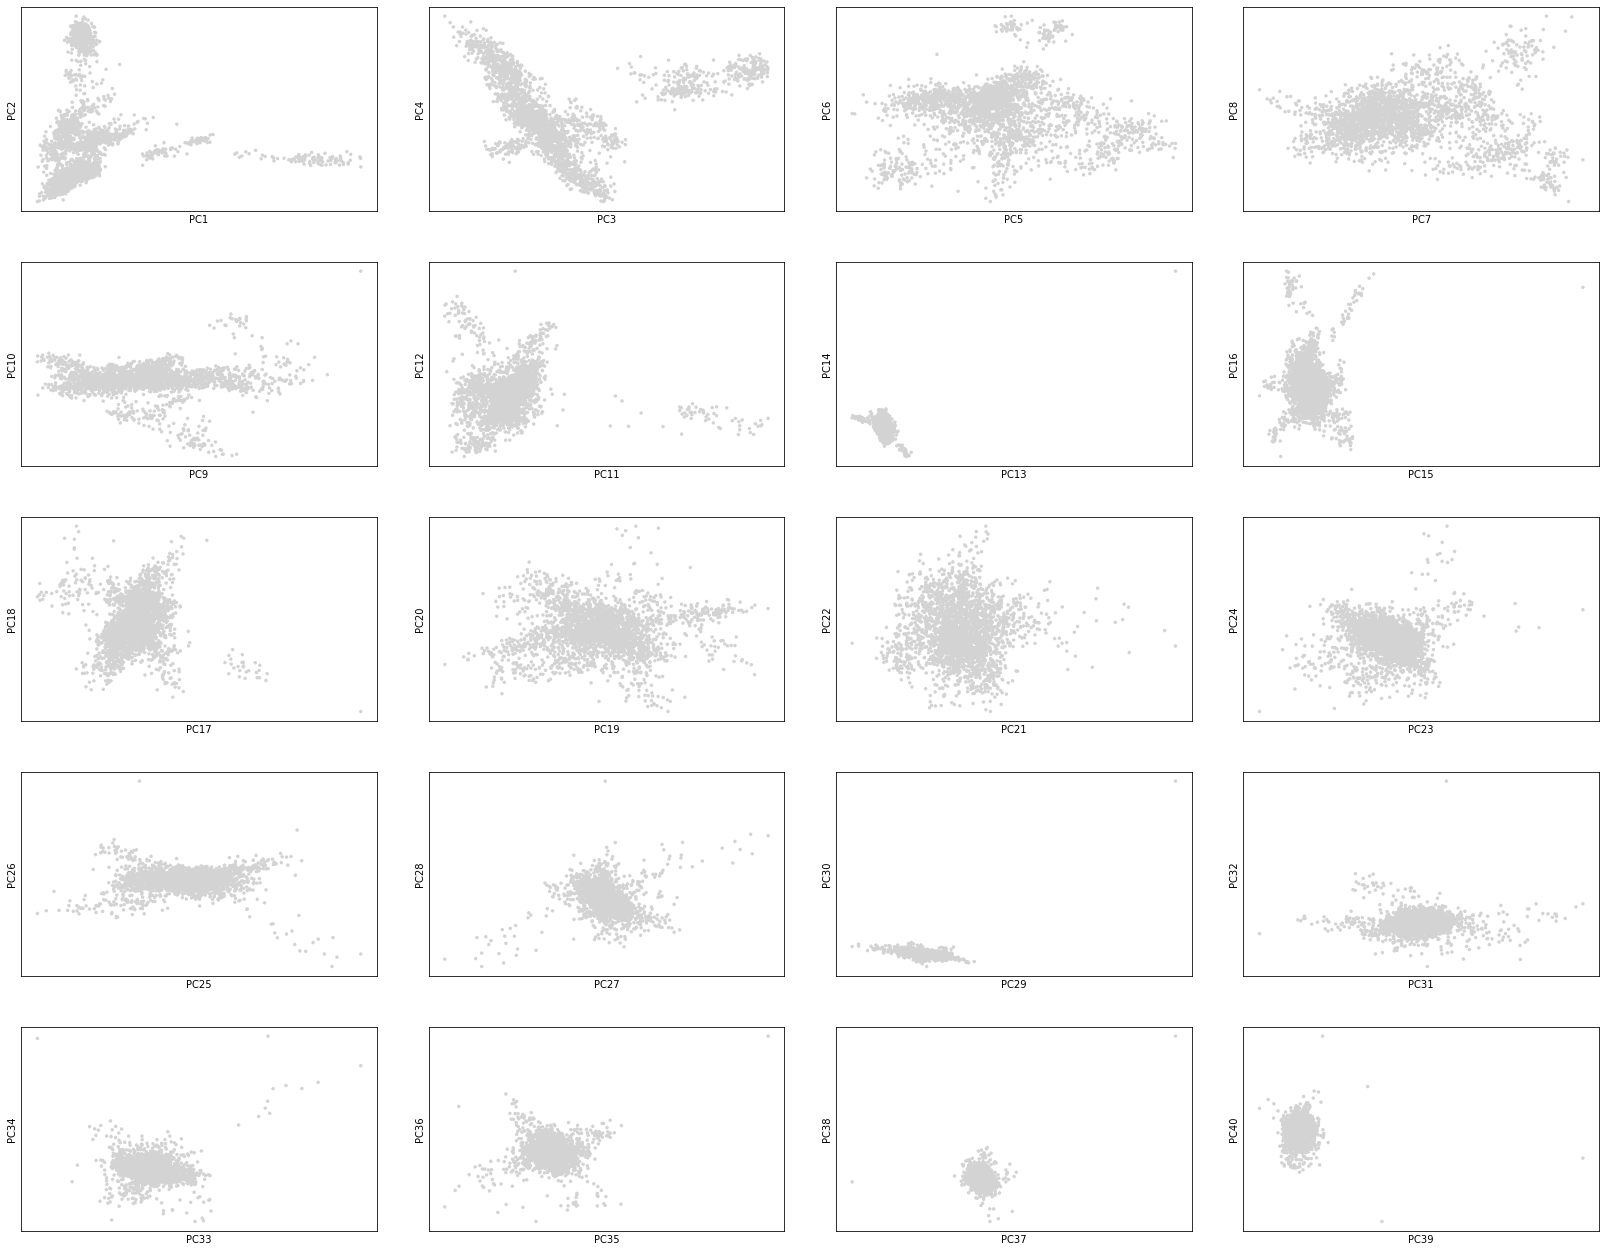

In [10]:
sc.pl.pca(ch_adata,
          components=[
              '1,2', '3,4', '5,6', '7,8', '9,10', '11,12', '13,14', '15,16',
              '17,18', '19,20', '21,22', '23,24', '25,26', '27,28', '29,30',
              '31,32', '33, 34', '35, 36', '37, 38', '39, 40'
          ],
          color=pc_color_col)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


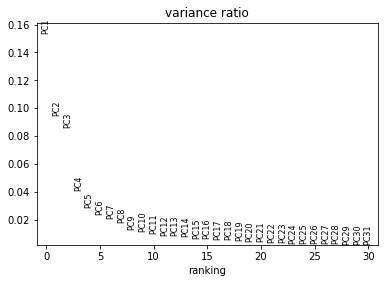

In [11]:
sc.pl.pca_variance_ratio(ch_adata)

### mCG

In [12]:
if batch_correction_col is None:
    sc.tl.pca(cg_adata, n_comps=50)
else:
    cg_adata.obs[batch_correction_col] = cell_meta[
        batch_correction_col].astype('category')
    cg_adata = batch_correct_pc(
        cg_adata,
        correct=True,
        batch_series=cg_adata.obs[batch_correction_col],
        dimred=50,
        sigma=sigma,
        alpha=alpha,
        knn=scanorama_k,
        metric='angular')

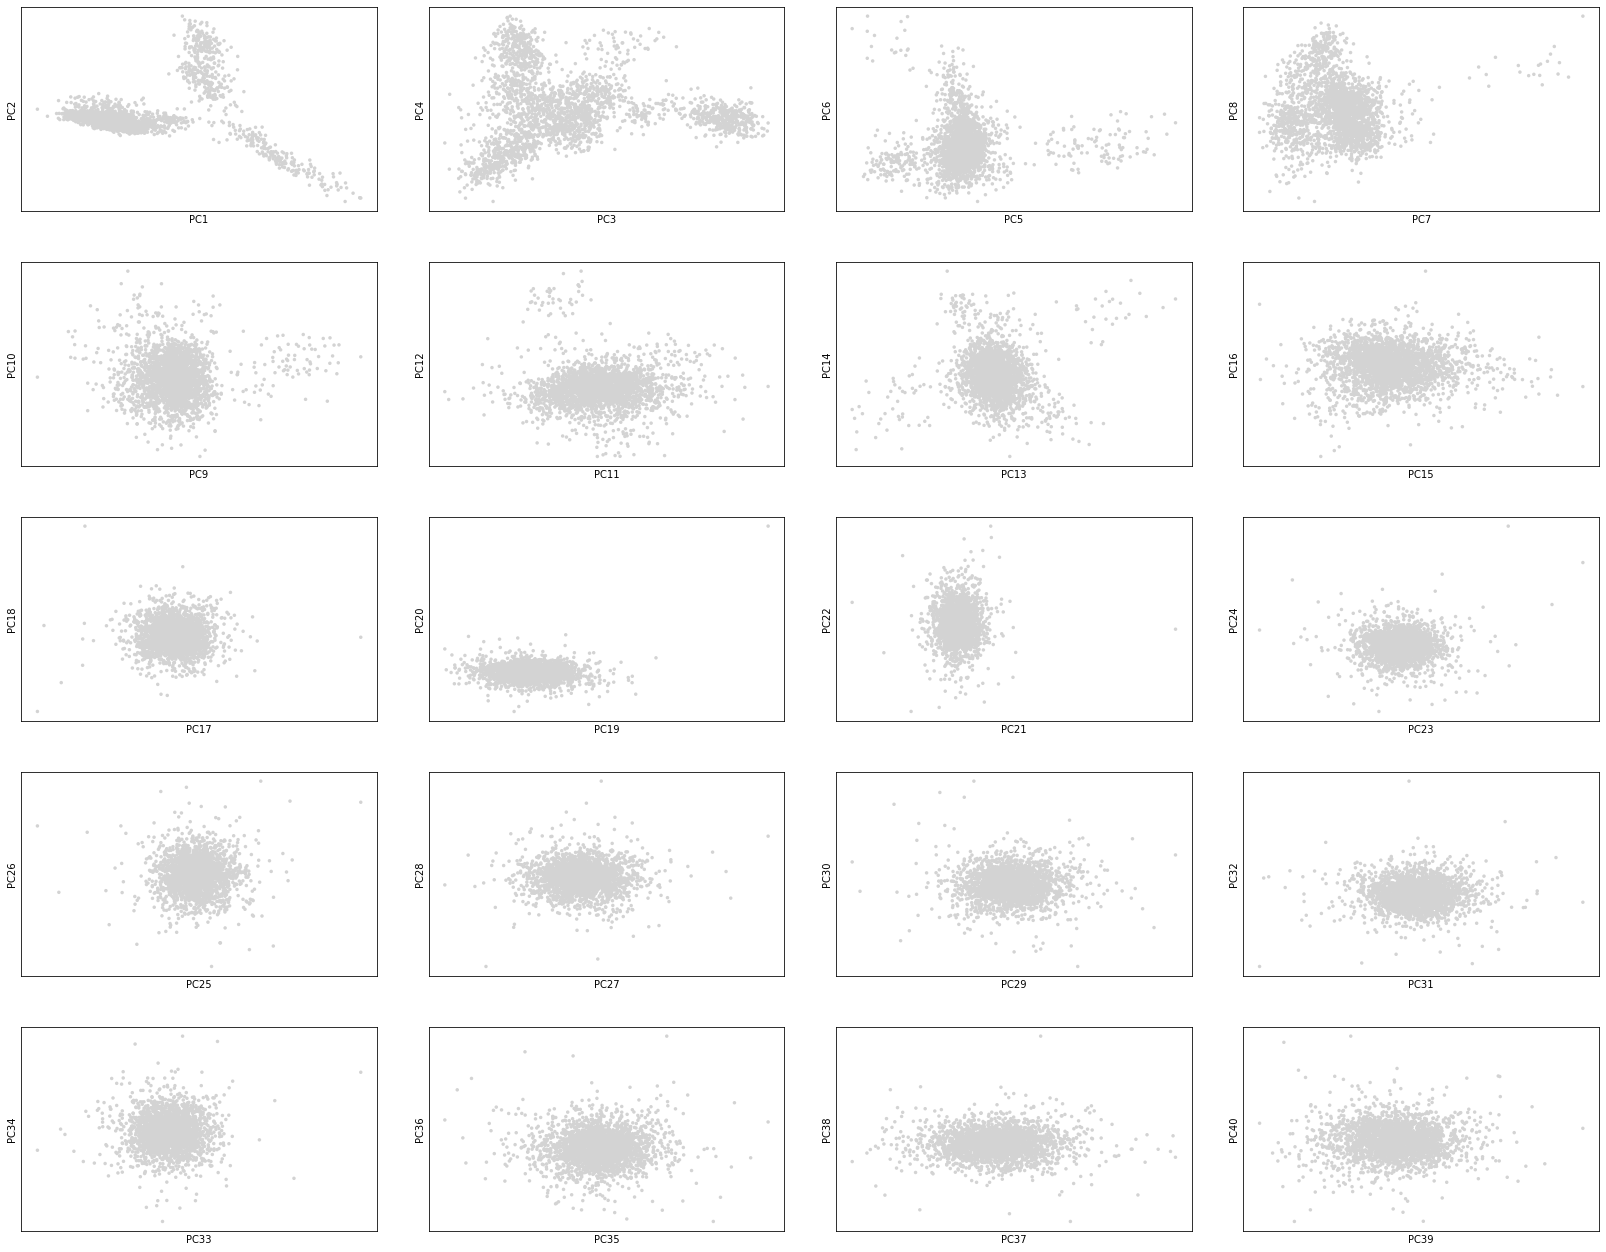

In [13]:
sc.pl.pca(cg_adata,
          components=[
              '1,2', '3,4', '5,6', '7,8', '9,10', '11,12', '13,14', '15,16',
              '17,18', '19,20', '21,22', '23,24', '25,26', '27,28', '29,30',
              '31,32', '33, 34', '35, 36', '37, 38', '39, 40'
          ],
          color=pc_color_col)

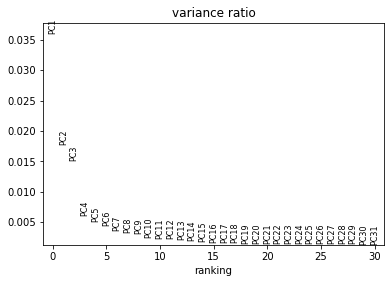

In [14]:
sc.pl.pca_variance_ratio(cg_adata)

### Concatenate

In [15]:
total_pca = np.concatenate([
    ch_adata.obsm['X_pca'][:, :ch_pc_components],
    cg_adata.obsm['X_pca'][:, :cg_pc_components]
],
                           axis=1)
adata = ch_adata.copy()
adata.obsm['X_pca'] = total_pca

## KNN

In [16]:
sc.pp.neighbors(adata, n_neighbors=n_neighbors)

## Simple Leiden

In [17]:
sc.tl.leiden(adata, resolution=resolution)

## UMAP

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


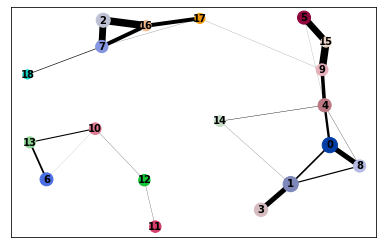

In [18]:
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata)
sc.tl.umap(
    adata,
    init_pos='paga',
    min_dist=0.5,
    spread=1.0,
    n_components=2,
    maxiter=None,
    alpha=1.0,
    gamma=1.0,
    negative_sample_rate=5,
)

## tSNE

In [19]:
sc.tl.tsne(adata, n_jobs=40, perplexity=perplexity)

## Save adata

In [20]:
adata.write_h5ad(result_dir / 'adata.with_pc_and_coords.h5ad')

## Get cell tidy data

In [21]:
def get_cell_tidy_data(adata, cell_meta):
    cell_meta = cell_meta.copy()
    cell_tidy_data = pd.DataFrame([], index=cell_meta.index)
    for col_name, col in adata.obs.iteritems():
        cell_tidy_data[col_name] = col
        try:
            del cell_meta[col_name]
        except KeyError:
            pass
    
    for k, v in adata.obsm.items():
        coord_name = k[2:]
        for i in range(2):
            cell_tidy_data[f'{coord_name}_{i}'] = v[:, i]
            try:
                del cell_meta[f'{coord_name}_{i}']
            except KeyError:
                pass
    cell_tidy_data = pd.concat(
        [cell_meta.reindex(adata.obs_names), cell_tidy_data],
        sort=True,
        axis=1)
    return cell_tidy_data

In [22]:
cell_tidy_data = get_cell_tidy_data(adata, cell_meta)
cell_tidy_data['leiden'] = cell_tidy_data['leiden'].astype(str)
cell_tidy_data.to_msgpack(result_dir / 'cell_tidy_data.msg')

## Plotting

In [23]:
cell_tidy_data = pd.read_msgpack(result_dir / 'cell_tidy_data.msg')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


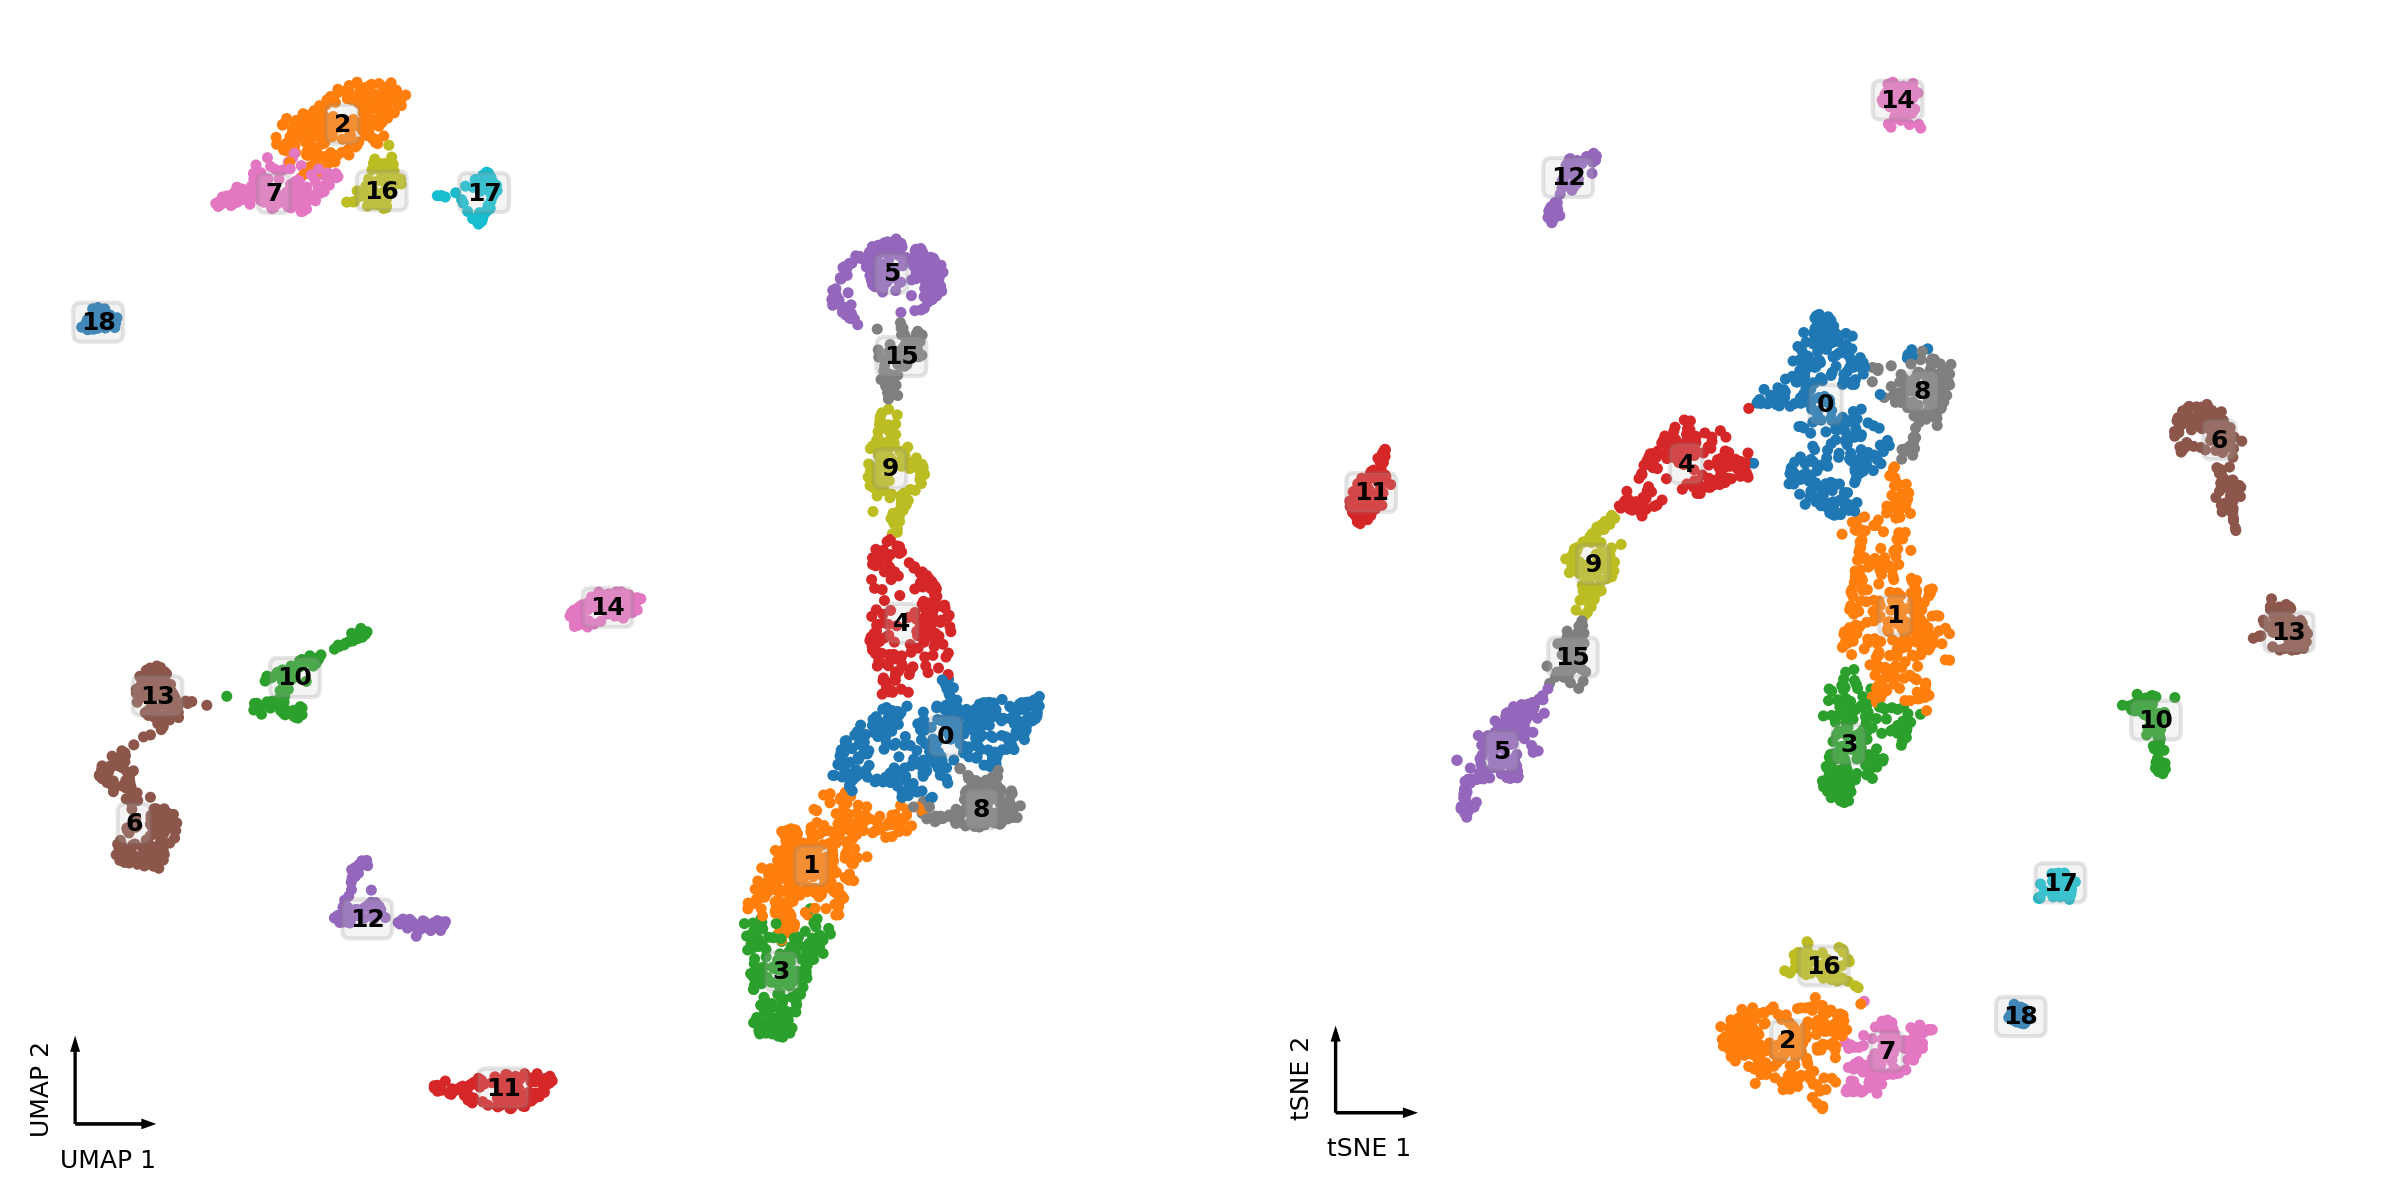

In [24]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), dpi=300, ncols=2)
categorical_scatter(cell_tidy_data,
                    ax1,
                    coord_base='umap',
                    hue='leiden',
                    text_anno='leiden',
                    text_anno_kws=dict(fontsize=6))
categorical_scatter(cell_tidy_data,
                    ax2,
                    coord_base='tsne',
                    hue='leiden',
                    text_anno='leiden',
                    text_anno_kws=dict(fontsize=6))
fig.savefig(fig_dir / 'leiden.on_umap_tsne.pdf')

### Metadata cols

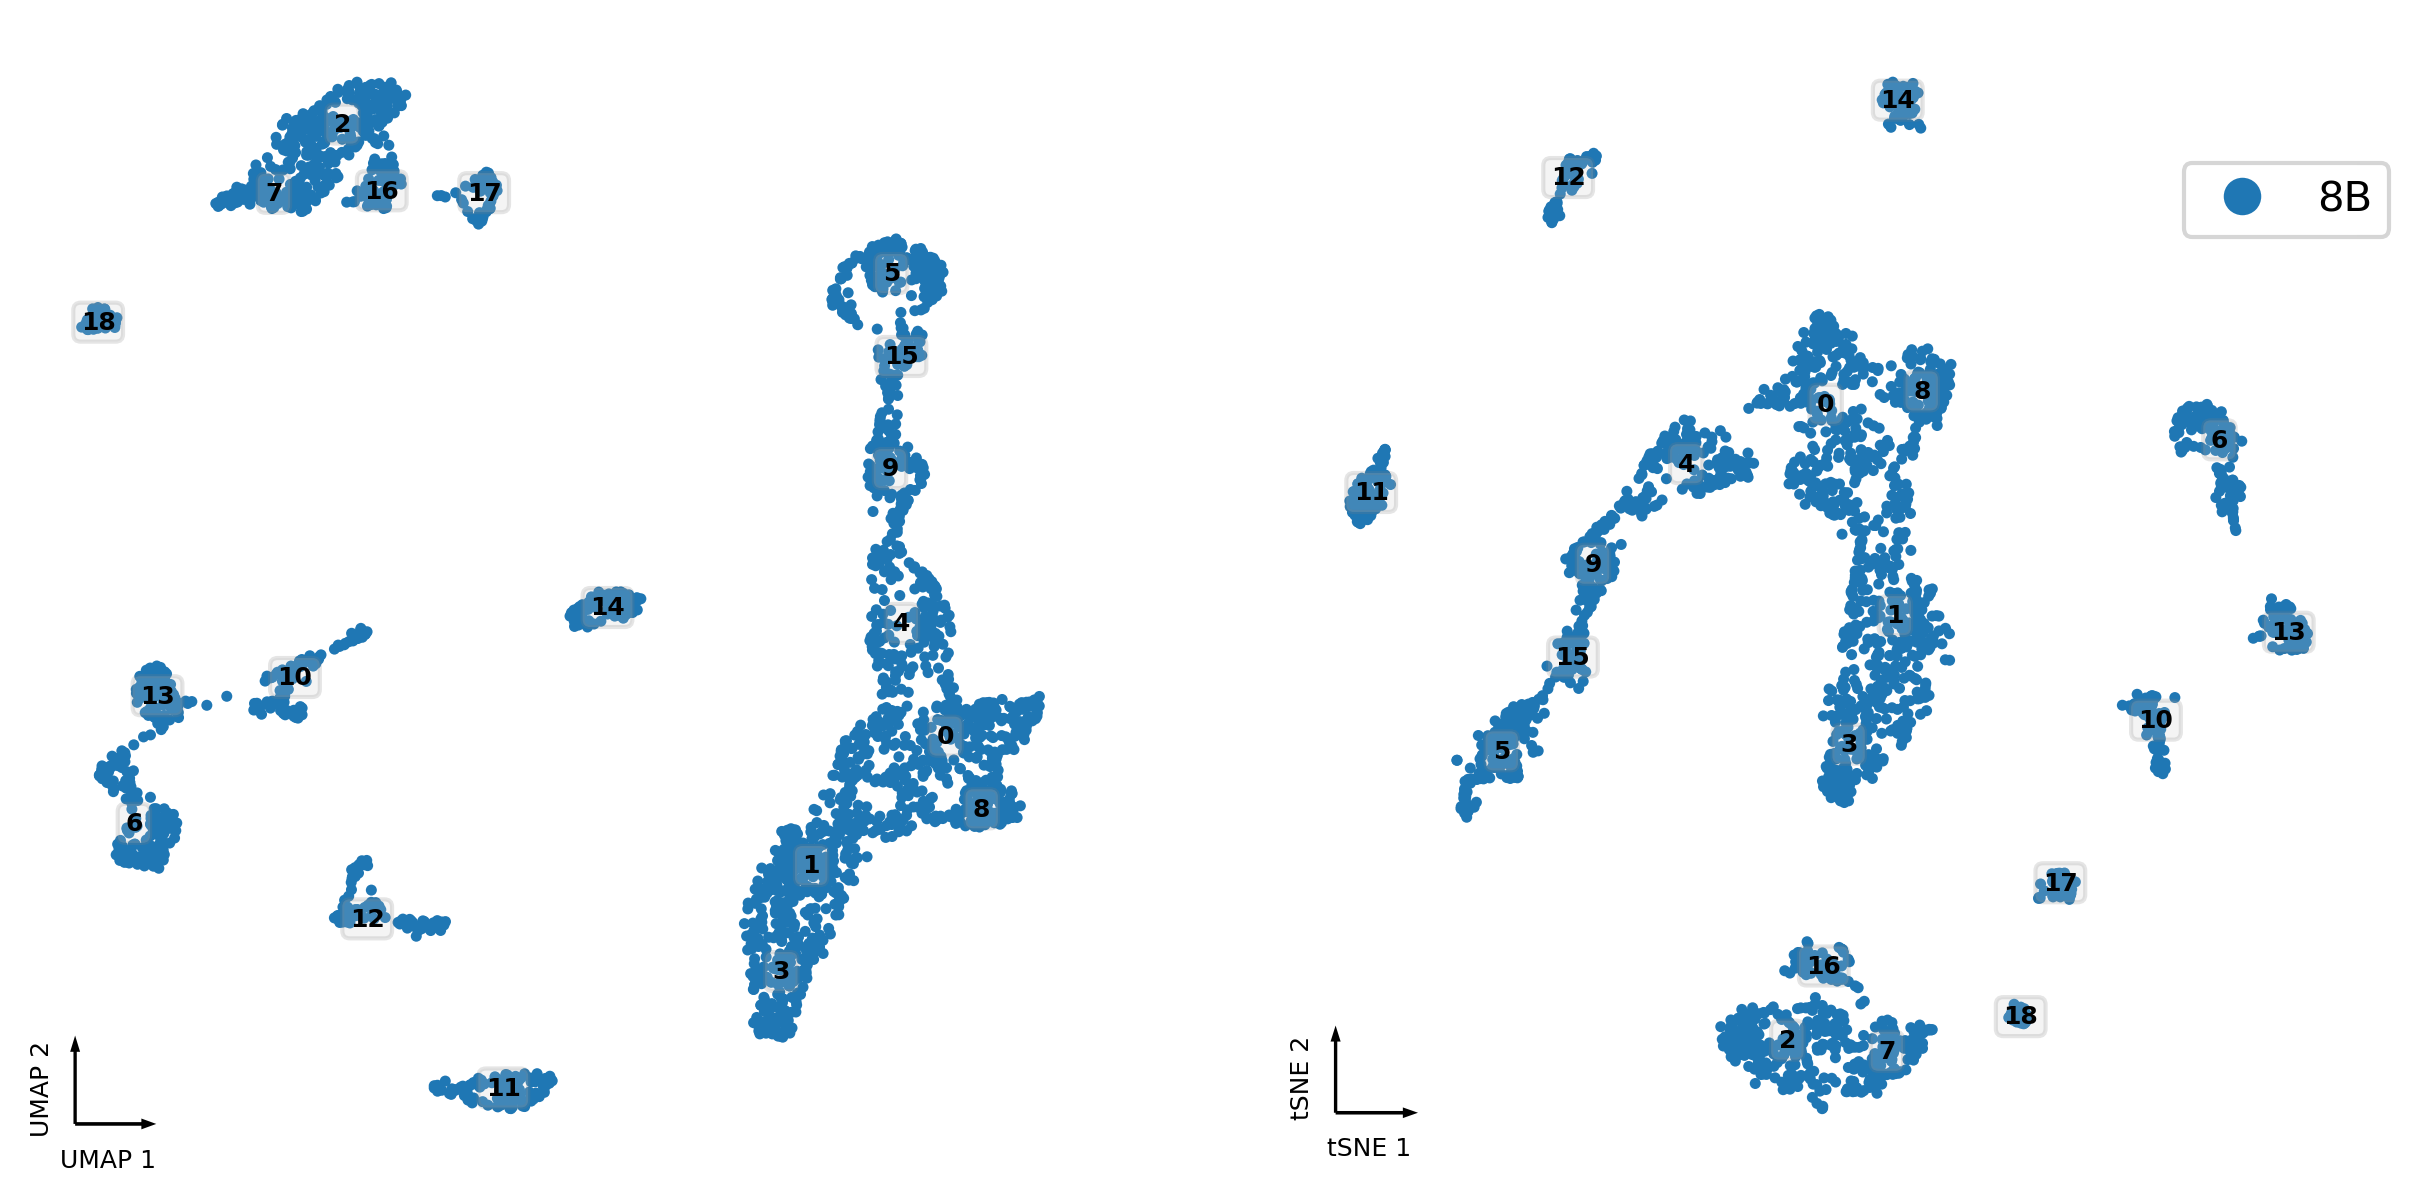

In [25]:
for hue in metadata_category_cols:
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), dpi=300, ncols=2)
    categorical_scatter(cell_tidy_data,
                        ax1,
                        coord_base='umap',
                        hue=hue,
                        text_anno='leiden',
                        text_anno_kws=dict(fontsize=6))
    categorical_scatter(cell_tidy_data,
                        ax2,
                        coord_base='tsne',
                        hue=hue,
                        text_anno='leiden',
                        text_anno_kws=dict(fontsize=6),
                        show_legend=True,
                        legend_kws=dict(bbox_to_anchor=(1.05, 0.9)))
    fig.savefig(fig_dir / f'{hue}.on_umap_tsne.pdf', bbox_inches='tight')

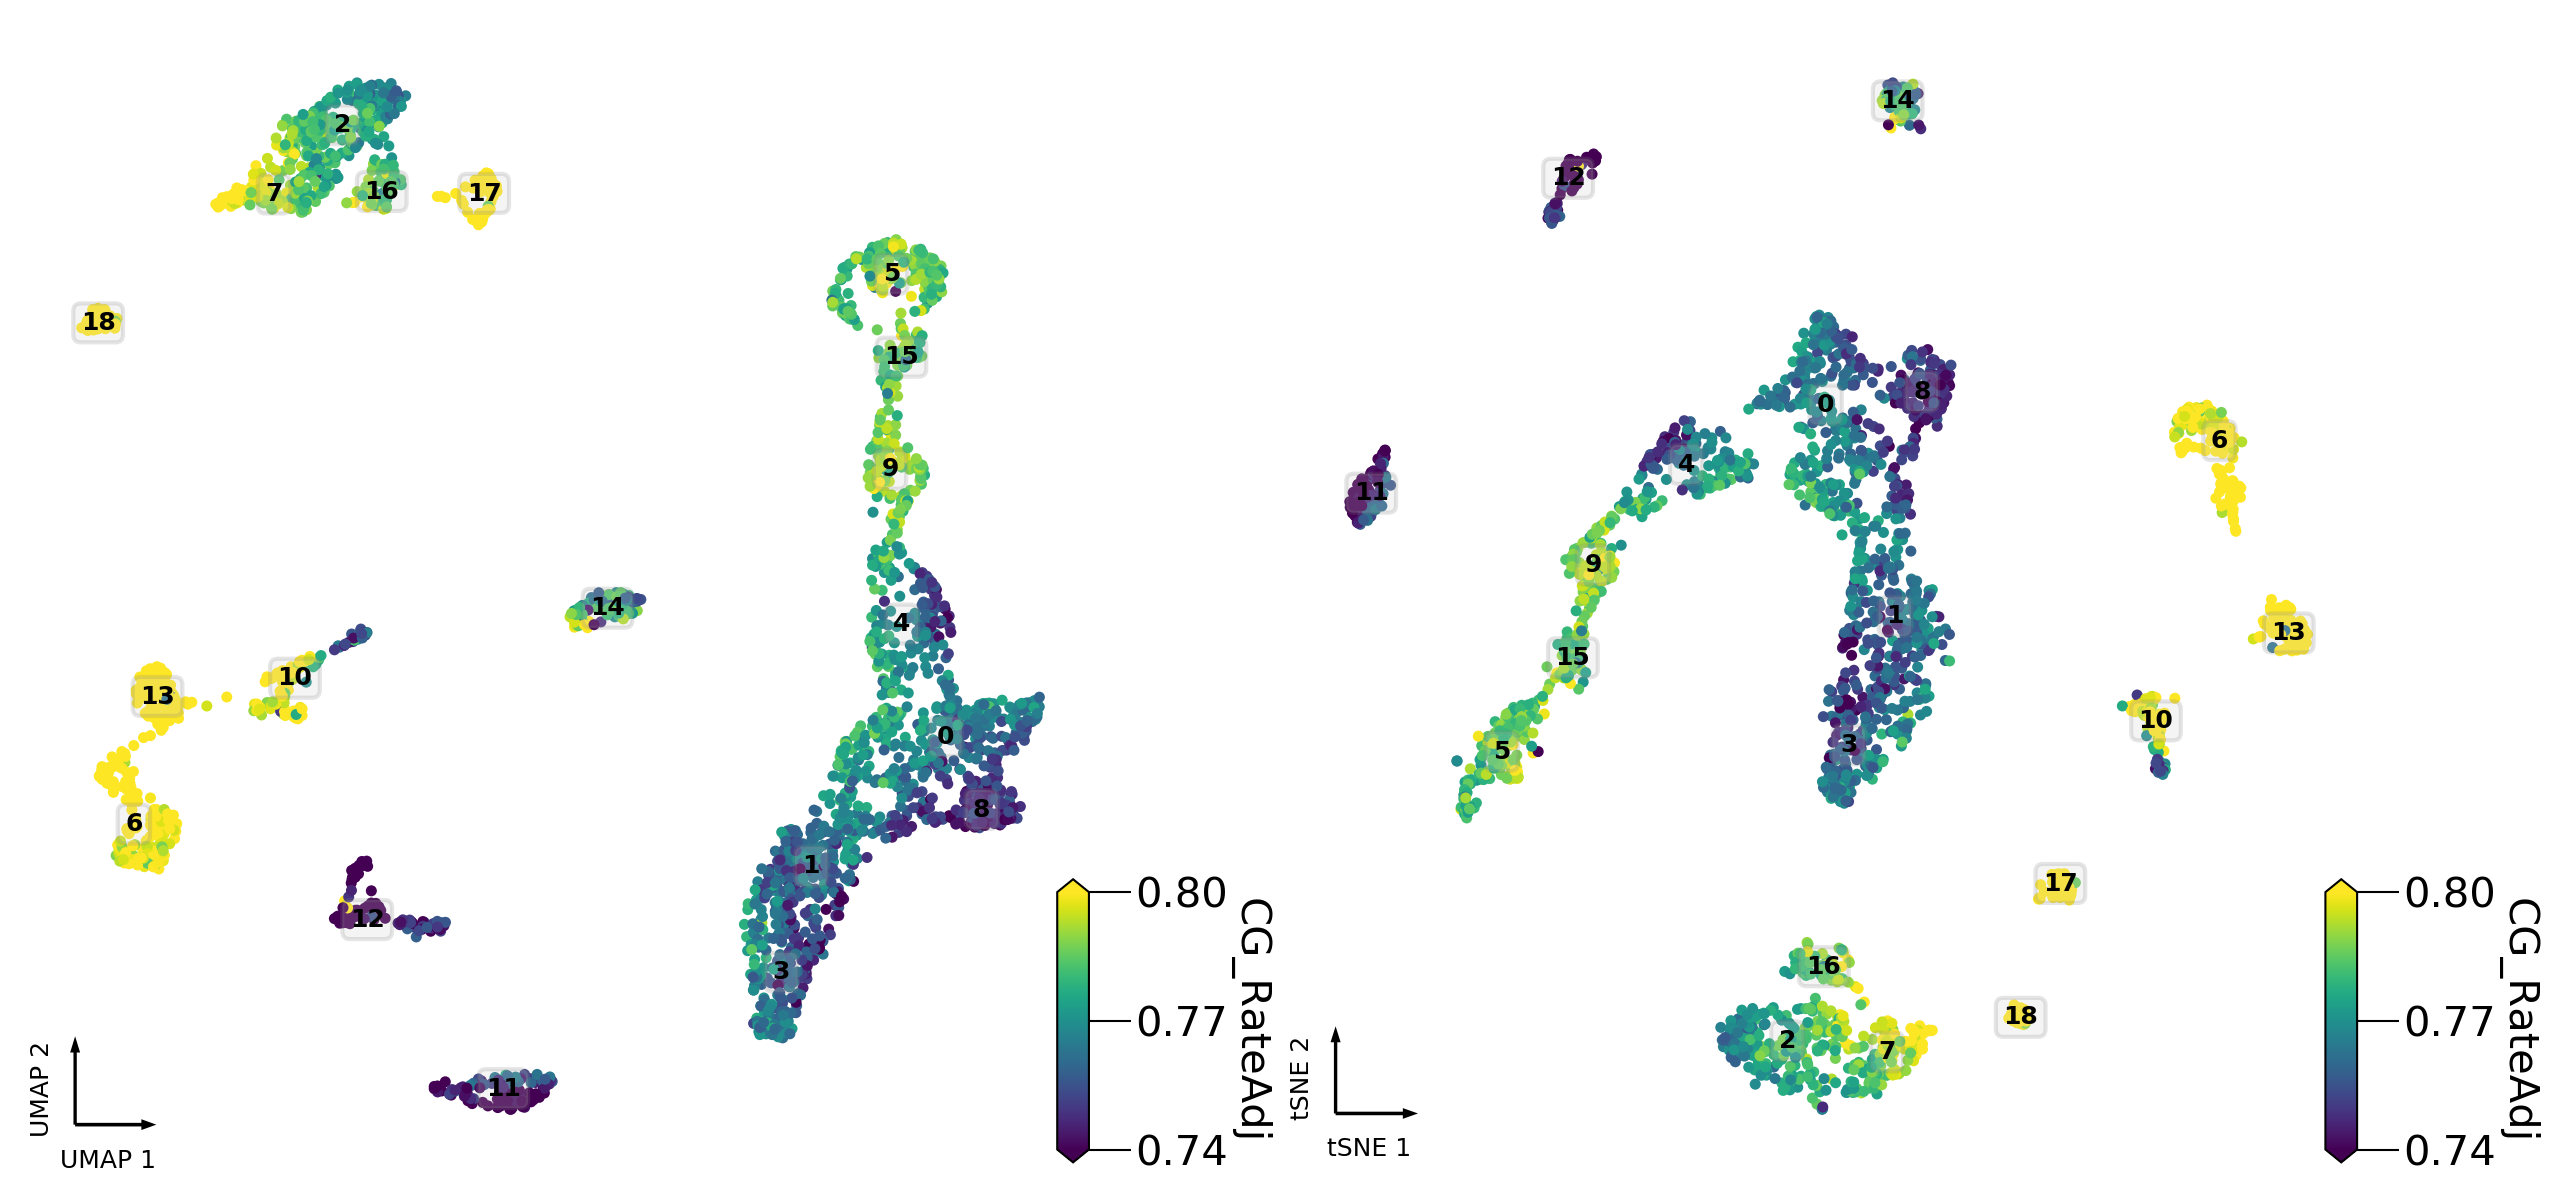

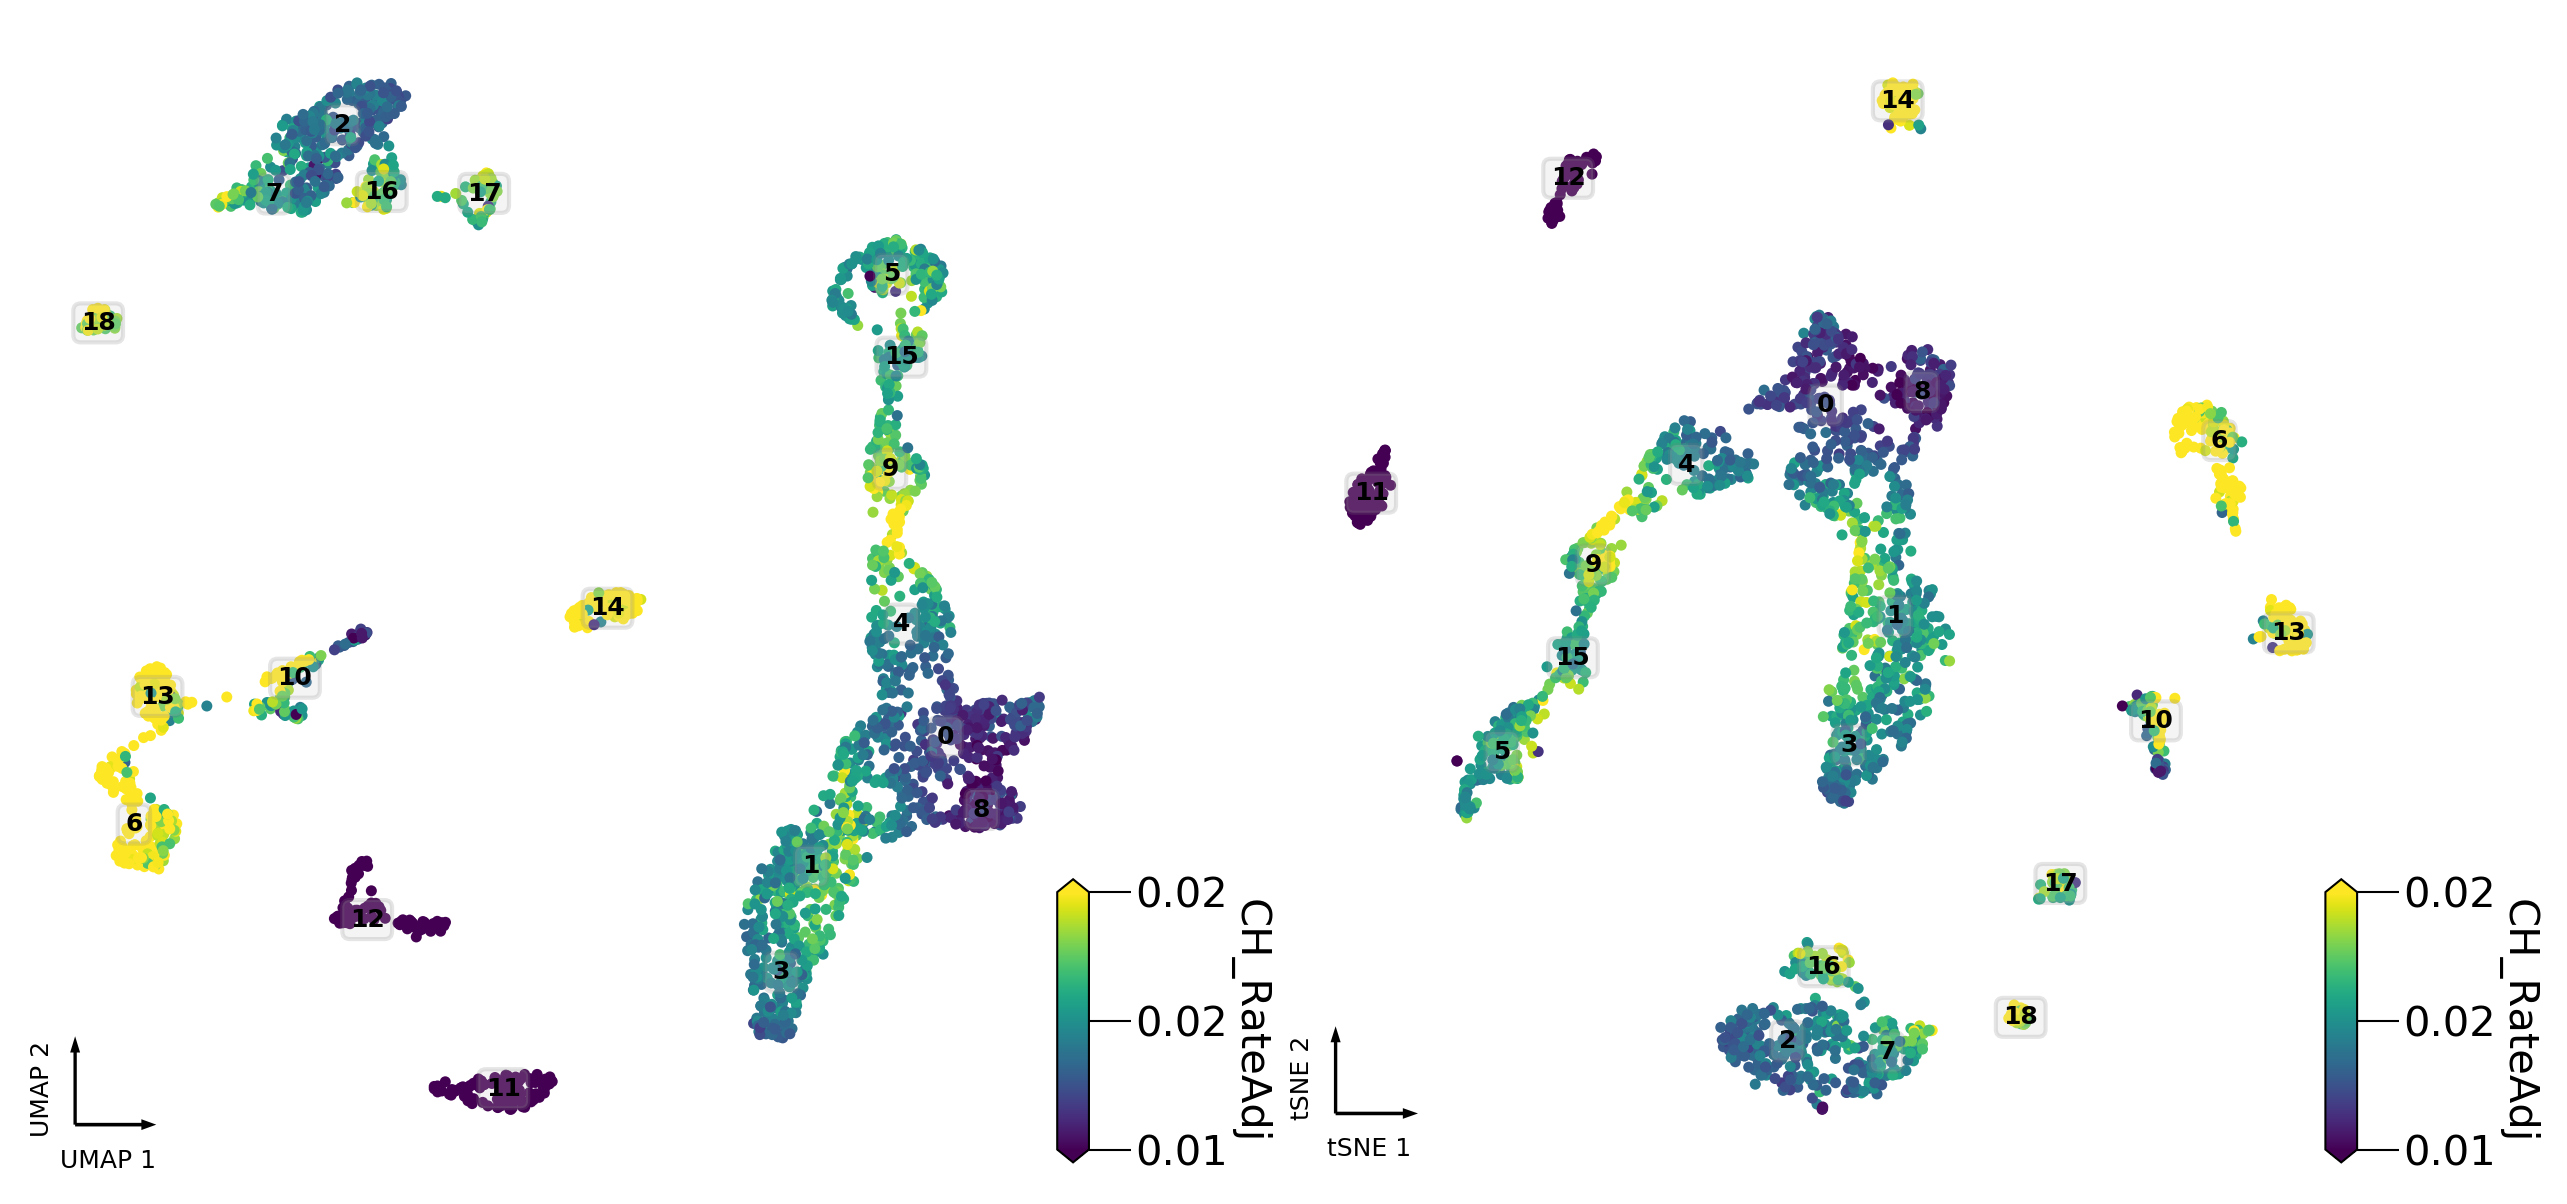

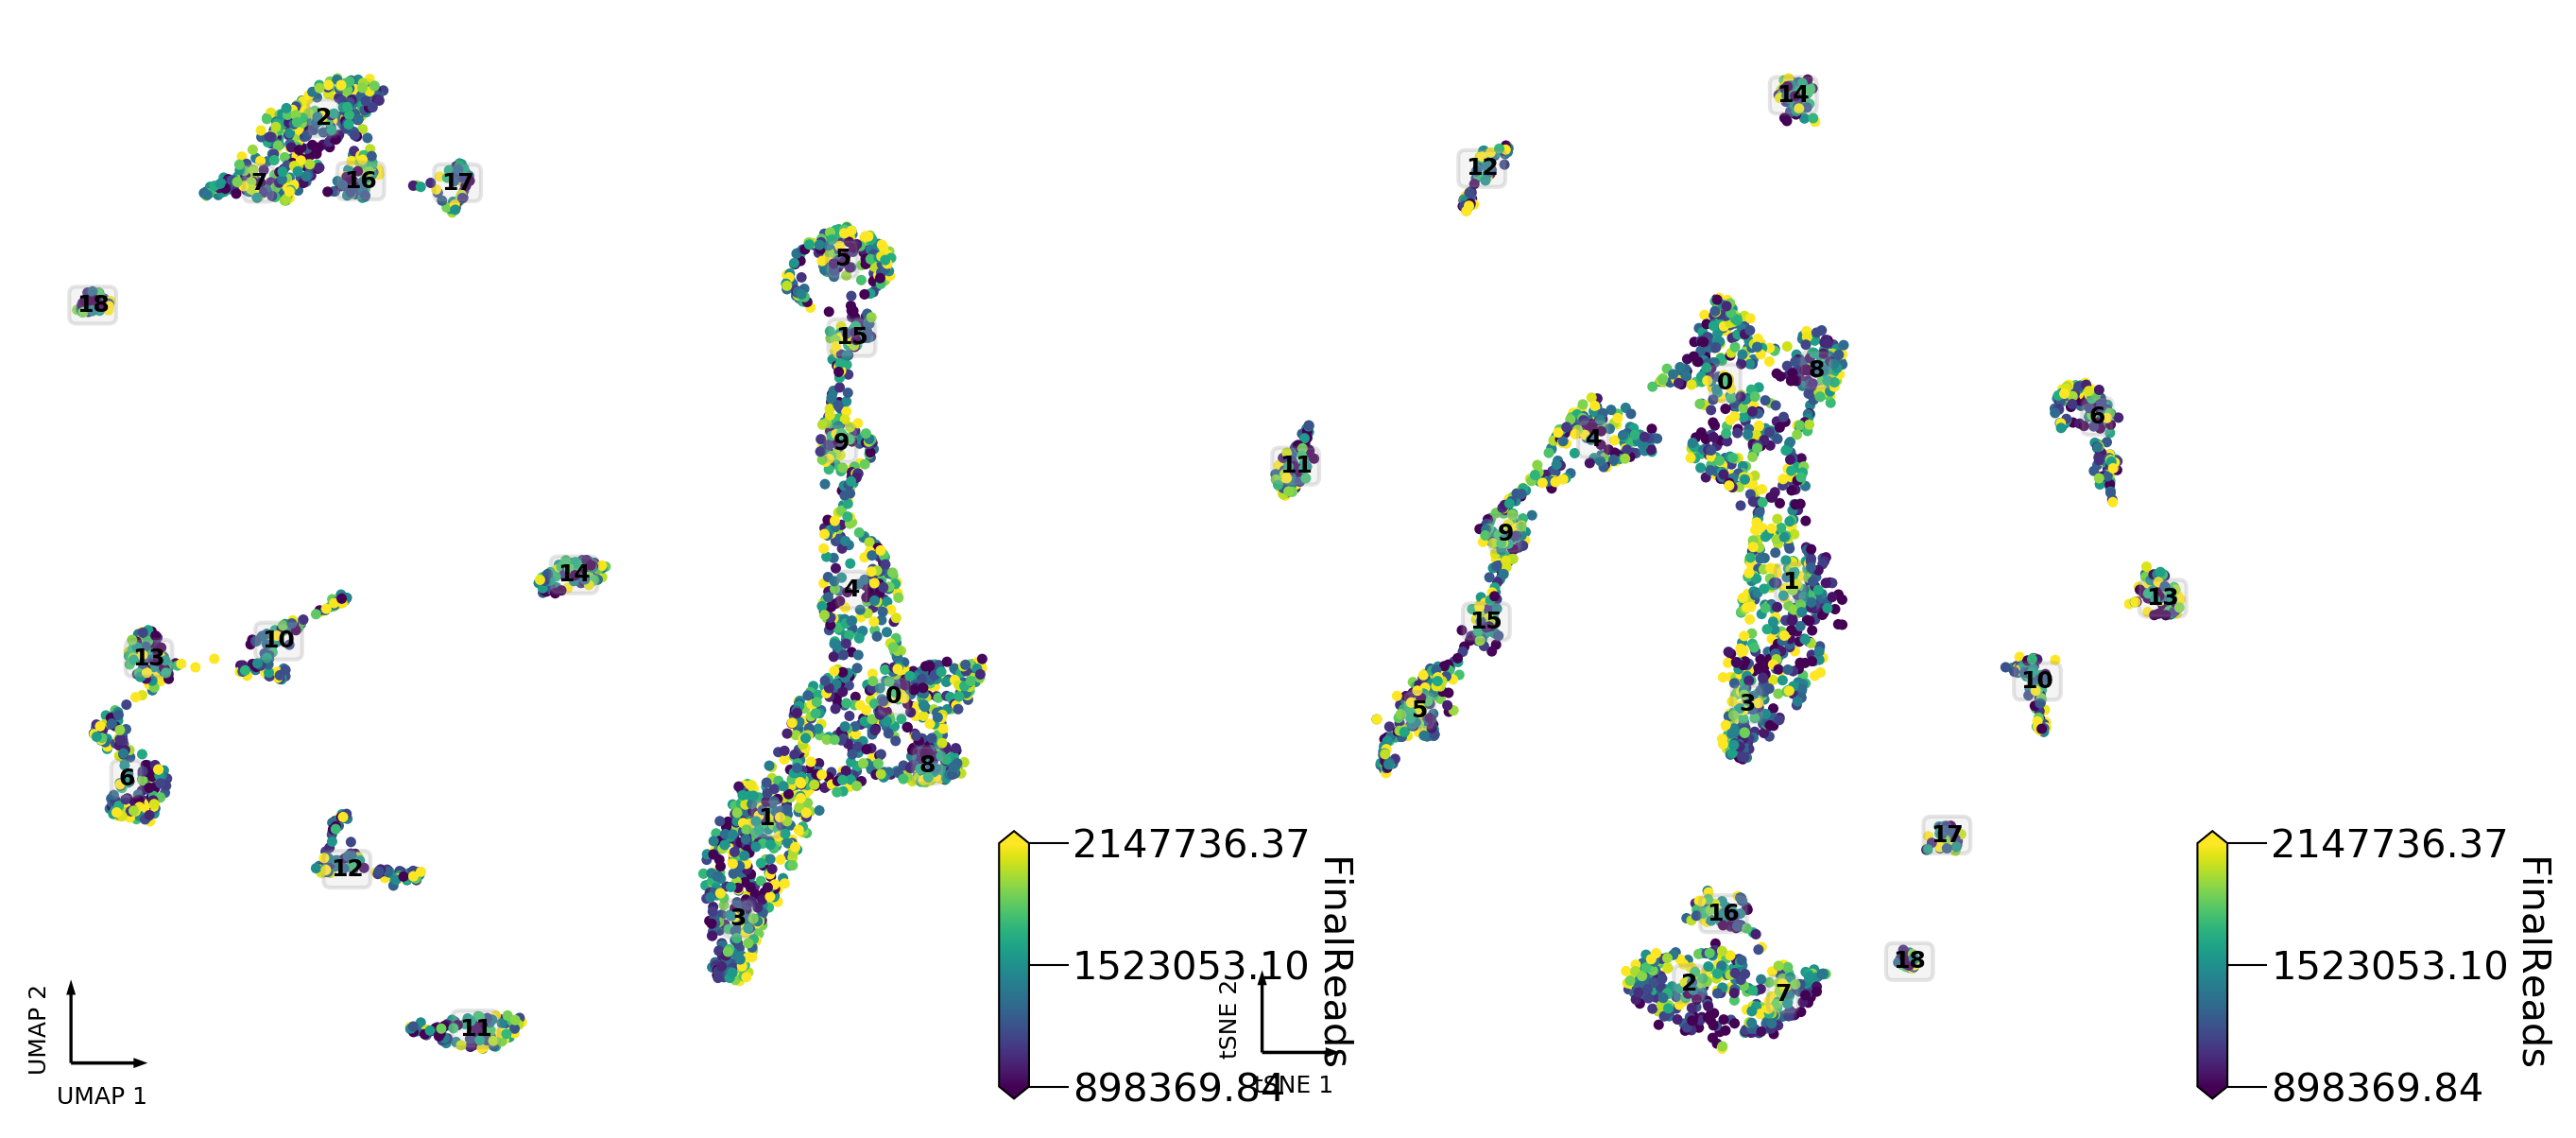

In [26]:
for hue in metadata_continue_cols:
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), dpi=300, ncols=2)
    continuous_scatter(cell_tidy_data,
                        ax1,
                        coord_base='umap',
                        hue=hue,
                        text_anno='leiden',
                        text_anno_kws=dict(fontsize=6))
    continuous_scatter(cell_tidy_data,
                        ax2,
                        coord_base='tsne',
                        hue=hue,
                        text_anno='leiden',
                        text_anno_kws=dict(fontsize=6))
    fig.savefig(fig_dir / f'{hue}.on_umap_tsne.pdf', bbox_inches='tight')